In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

# Disable CUDA graphs
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import predict, get_all_metrics

In [148]:
run_dir = Path("../runs/transformer_30/20240604_2258")
cfg, model, trainer_state, opt_state = load_last_state(run_dir)
cfg['quiet'] = False
dataset = TAPDataset(cfg)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']


Loading Basins:   0%|          | 0/740 [00:00<?, ?it/s]

In [149]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

In [150]:
cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
dataloader = TAPDataLoader(cfg, dataset)

results, metrics = predict(model, dataloader, seed=0, denormalize=True, return_features=True)


Dataloader using 2 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/188 [00:40<?, ?it/s]

nBias: 0.6820
rRMSE: 30.9831
KGE: -0.2508
NSE: -23.9877
lNSE: 0.0048
Agreement: 0.1217


/work/pi_kandread_umass_edu/tss-ml/src/evaluate.py:105: RuntimeWarning: invalid value encountered in log
  return 1 - (numerator / denominator)


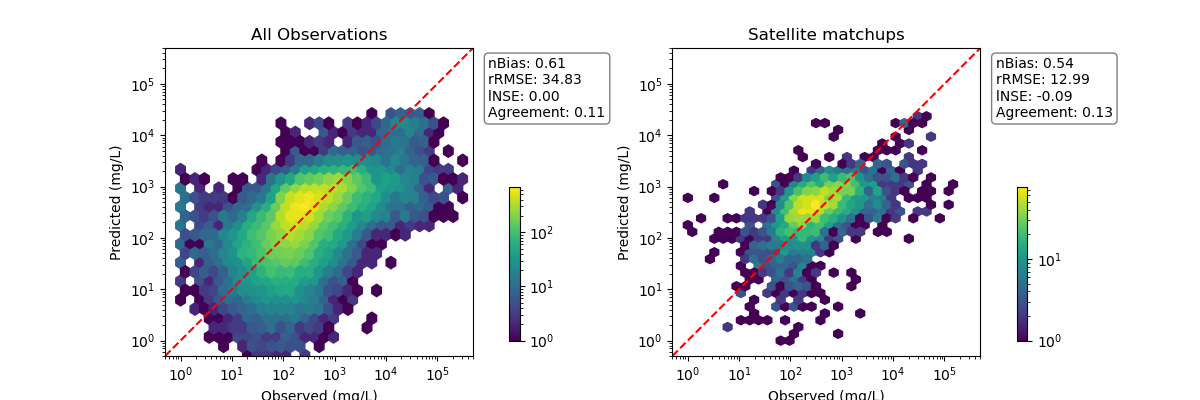

In [151]:
plt.close('all')

reload(evaluate)
from evaluate import get_all_metrics

def scatter_1to1(ax, x, y, unit):
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]

    hb = ax.hexbin(x, y, gridsize=(30,20), bins='log', xscale='log', yscale='log')
    cb = plt.colorbar(hb, shrink=0.5, aspect=15, anchor=(0,0.1))
    
    # Adding a 1:1 line over the min and max of x and y
    min_val = 5E-1
    max_val = 5E5
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    metrics = get_all_metrics(x,y)
    textstr = '\n'.join([f"{key}: {metrics[key]:0.2f}" for key in ['nBias', 'rRMSE', 'lNSE', 'Agreement']])
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.05, 0.97, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # Setting axes to be square and equal range
    ax.axis('square')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xlabel(f'Observed ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')
    
    
fig, axes = plt.subplots(1,2, figsize=(12, 4))
unit = 'mg/L'

x = results['obs']
y = results['pred']
scatter_1to1(axes[0], x, y, unit)
axes[0].set_title('All Observations')

x = x[results['matchups']]
y = y[results['matchups']]
scatter_1to1(axes[1], x, y, unit)
axes[1].set_title('Satellite matchups')


plt.show()
fig.savefig(run_dir / "density_scatter.png",  dpi=300)

In [156]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()
# basin = 'USGS-09367540'

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results, metrics = predict(model, dataloader, seed=0, denormalize=True, return_features=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop(columns=['basin'])
results.set_index('date', inplace=True)


Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/12 [00:00<?, ?it/s]

nBias: nan
rRMSE: nan
KGE: nan
NSE: nan
lNSE: nan
Agreement: nan


/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/work/pi_kandread_umass_edu/tss-ml/src/evaluate.py:78: RuntimeWarning: Mean of empty slice
  y, y_hat = _mask_nan(y, y_hat)
/work/pi_kandread_umass_edu/tss-ml/src/evaluate.py:83: RuntimeWarning: Mean of empty slice
  std_y = np.std(y)
/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/tlanghorst_um

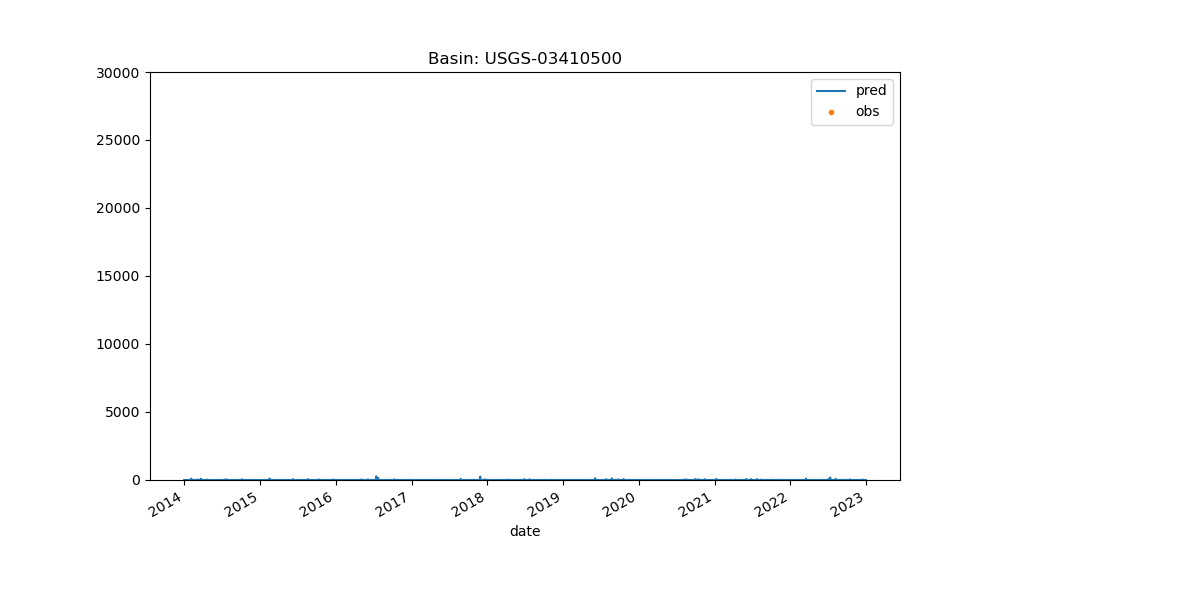

In [157]:
# Plot the true values and predictions
plt.close('all')
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(right=0.75)  # Adjust right margin to make room for text

pred = results['pred']
obs = results['obs']

pred.plot(ax=ax)
obs.plot(ax=ax,linestyle='None',marker='.')

plt.title(f"Basin: {basin}")
plt.legend()
fig.autofmt_xdate()
plt.ylim([0,30000])
plt.show()